# This file is used to check the images

In [1]:
import pandas as pd
import SimpleITK as sitk
import torch
import torchio as tio
import numpy as np
import os
import copy
import ast
import matplotlib.pyplot as plt

In [3]:
def information(pathology_num, view):
    location_csv = pd.read_csv('./new_location.csv')
    pathologys = location_csv.columns.tolist()
    pathology = pathologys[pathology_num]

    # Read the file names
    location_csv_pathology = location_csv[~location_csv[pathology].isnull()]
    names = location_csv_pathology['StudyUID'].tolist()
    
    knee_image = []
    pixel_image = []
    slice_num = []
    
    i = 0
    while i < 20:
        location_label = location_csv.loc[location_csv['StudyUID'] == names[i]][pathology].tolist()

        # Get knee images
        root_path = './previous_dataset/Preprocessed_dataset_2'
        study_path = os.path.join(root_path, names[i], f'{view.upper()}_PROTON.nii')
        img = tio.ScalarImage(study_path)
        sitk_img = img.as_sitk()

        # Get the pixel locations and slice information
        physical_location = ast.literal_eval(location_label[0])

        pixel_location = sitk_img.TransformPhysicalPointToIndex(physical_location)
        slice = pixel_location[2]
        if view == "transversal":
            if slice > 27:
                continue
        else:
            if slice > 25:
                continue
        knee_image.append(img.data)
        slice_num.append(slice)

        # Get the pixel images
        STD = [6.0, 6.0, 6.0, 6.0, 1.0, 1.0]

        pixel_map = copy.deepcopy(img)
        pixel_map_data = torch.zeros_like(pixel_map.data)
        pixel_map_data[0, pixel_location[0],
                        pixel_location[1], pixel_location[2]] = 1.0
        pixel_map.set_data(pixel_map_data.type(torch.float32))
        pixel_map = tio.transforms.RandomBlur(
            std=STD)(pixel_map)
        pixel_map = pixel_map.data
        pixel_image.append(pixel_map)

        i += 1

    return pathology, knee_image,pixel_image,slice_num

In [6]:
def plot(knee_images, pixel_images, slices, pathology, title=None):
    i = 0
    fig, ax = plt.subplots(nrows=20,ncols=3,figsize=(20,150))
    plt.axis('off')
    while i < 20:
        knee_image = knee_images[i].squeeze()
        pixel_image = pixel_images[i].squeeze()
        slice = slices[i]
        ax[i,0].imshow(torch.rot90(knee_image[:, :, slice],dims=[1,0]), cmap='gray')
        ax[i,0].set_xlabel(f'Case {i+1}, Slice {slice}',fontsize = 14)
        ax[i,1].imshow(torch.rot90(pixel_image[:, :, slice],dims=[1,0]), cmap='gray')
        ax[i,1].set_xlabel(f'Location of {pathology}',fontsize = 14)
        ax[i,2].imshow(torch.rot90(knee_image[:, :, slice],dims=[1,0]), cmap='gray',alpha=0.7)
        ax[i,2].imshow(torch.rot90(pixel_image[:, :, slice],dims=[1,0]), alpha=0.3)
        ax[i,2].set_xlabel('Combination of label and image',fontsize = 14)
        i += 1

    if title:
	    fig.suptitle(title, fontsize=16)
    
    plt.show()

In [5]:
pathology_num = 1
view = "sagittal"

pathology, knee_images, pixel_images, slices = information(pathology_num,view)

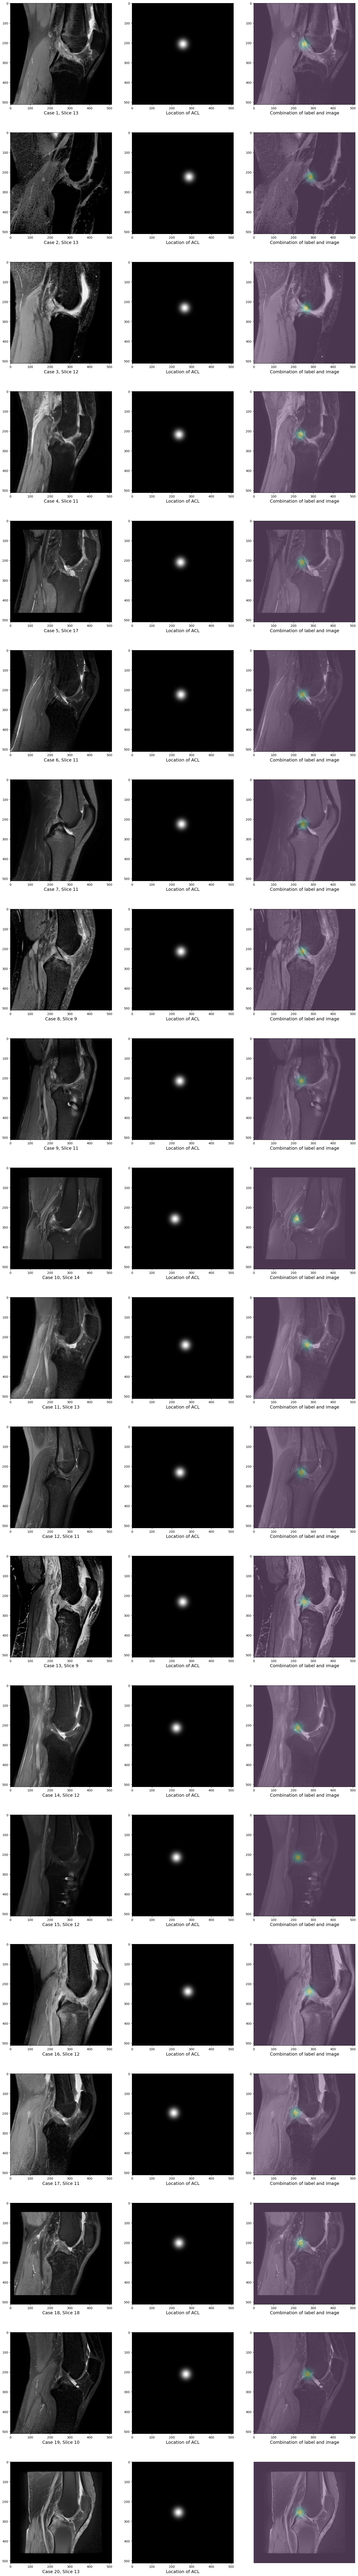

In [7]:
plot(knee_images, pixel_images, slices, pathology)

*Creat csv file for index*

In [7]:
import pandas as pd

location_csv = pd.read_csv('./new_location.csv')
pathologys = location_csv.columns.tolist()
dictionary = {}
i = 1
while i < len(pathologys):
    dictionary[f'disease_{i}'] = [pathologys[i]]
    i += 1

print(dictionary)
df = pd.DataFrame(dictionary).T
df.to_csv("./example_images/contents.csv",index=True)

{'disease_1': ['ACL'], 'disease_2': ['Meniscus'], 'disease_3': ['bakerzyste'], 'disease_4': ['Femuropatellargelenks Dysplasie-Hypoplasie'], 'disease_5': ['Einklemmung-Plica med.'], 'disease_6': ['Einklemmung-Hoffa FK'], 'disease_7': ['Innenmeniskus-Extrusion/Luxation und Außenmeniskus-Extrusion/Luxation'], 'disease_8': ['Synovia-Erguß'], 'disease_9': ['Femur-Oedem'], 'disease_10': ['Synovia-Bakerzysten-/Kapselruptur'], 'disease_11': ['Außenband-Signalanhebung'], 'disease_12': ['Innenband-Signalanhebung'], 'disease_13': ['Femur-Fraktur/Fissur']}


In [2]:
import ipywidgets as widgets
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torchio as tio

original_dataset = "./previous_dataset/PraxisData"
current_dataset = "./previous_dataset/Preprocessed_dataset_2"
view = "coronal"
case_name = "1.2.840.113619.6.95.31.0.3.4.1.3096.13.156129"

original_image_dir = f"{original_dataset}/{case_name}/{view.upper()}_PROTON.nii"
current_image_dir = f"{current_dataset}/{case_name}/{view.upper()}_PROTON.nii"

shape = tio.ScalarImage(current_image_dir).shape
print(f"shape: {shape}")

img = sitk.ReadImage(original_image_dir)
series = sitk.GetArrayFromImage(img).astype(np.float32)
depth = series.shape[0]

@widgets.interact(axial_slice=(0,depth-1))

def axial_slicer(axial_slice=10):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # Show the image of the specified slice number in 'gray' color-map
    # and axial aspect ratio
    ax.imshow(series[axial_slice,:,:], cmap='gray')

    # Don't show the axis
    ax.axis('off')

shape: (1, 512, 512, 27)


interactive(children=(IntSlider(value=10, description='axial_slice', max=23), Output()), _dom_classes=('widget…

# Save the too thick dataset's name into a csv file

In [1]:
import SimpleITK as sitk
import torchio as tio
from glob import glob
import pandas as pd
import os

dataset_dir = "./previous_dataset/PraxisData"
case_paths = sorted(glob(f"{dataset_dir}/**"))
print(len(case_paths))

views = ['coronal','sagittal','transversal']
problem_name = []

for view in views:
    for case_path in case_paths:
        path = f"{case_path}/{view.upper()}_PROTON.nii"
        name = os.path.basename(case_path)
        shape = tio.ScalarImage(path).shape
        depth = shape[3]
        if depth > 50:
            # print(f"In {view}, {name} has a shape {shape}")
            if not name in problem_name:
                problem_name.append(name)

dictionary = {}
dictionary["slice>50"]= problem_name
df = pd.DataFrame(dictionary)
df.to_csv("./previous_dataset/problem_dataset_from_PraxisData/too_large.csv",index=False)

3794


*Check whether there is some overlap in the coordinate label*

In [3]:
import numpy as np
location_csv = pd.read_csv("./new_labels.csv")
names = location_csv["StudyUID"].tolist()
print(len(names))
unique_names = np.array(names)
unique_names = (np.unique(unique_names)).tolist()
print(len(unique_names))

3054
3054


*Check whether the ACL label is the same from the old label to the new label*

In [ ]:
import pandas as pd

